<a href="https://colab.research.google.com/github/sakshamkumar1/tensorflow-notebooks/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-tuning

In [1]:
import tensorflow as tf

tf.config.list_physical_devices("gpu")

[]

In [2]:
!nvidia-smi

Wed Apr 26 03:20:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-04-26 03:20:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-26 03:20:58 (105 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-04-26 03:20:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 172.253.62.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  96.6MB/s    in 1.7s    

2023-04-26 03:21:01 (96.6 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [7]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [8]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[5.88265305e+01 3.65714302e+01 2.04081631e+00]
   [5.46683655e+01 3.16428566e+01 2.11734700e+00]
   [5.10051003e+01 3.00663261e+01 3.57142878e+00]
   ...
   [4.57140684e+00 2.57140684e+00 5.99993467e+00]
   [3.78572750e+00 1.81124234e+00 2.73469758e+00]
   [6.19899225e+00 5.19899225e+00 3.19899225e+00]]

  [[7.34540787e+01 4.85714302e+01 1.50000000e+01]
   [7.05714264e+01 4.52857132e+01 1.44897957e+01]
   [6.80153046e+01 4.38724480e+01 1.82602043e+01]
   ...
   [2.19895935e+00 1.98959351e-01 3.59687805e+00]
   [4.22451782e+00 2.36228490e+00 2.93877745e+00]
   [1.09286413e+01 9.92864132e+00 7.12245369e+00]]

  [[8.49387741e+01 5.57908173e+01 2.55051003e+01]
   [8.39438705e+01 5.45000000e+01 2.62704067e+01]
   [8.30459137e+01 5.37346916e+01 2.85459175e+01]
   ...
   [4.35714245e+00 2.35714245e+00 5.35714245e+00]
   [9.21433735e+00 8.21433735e+00 6.07145405e+00]
   [1.79235649e+01 1.69235649e+01 1.26429262e+01]]

  ...

  [[9.21935558e+00 9.21935558e+00 1.12193556e+01]
   [8

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

In [12]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated.)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50V2 we will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_feature_extraction")])

16705208/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230426-032110


Epoch 1/5
24/24 [==============================] - 36s 506ms/step - loss: 1.8476 - accuracy: 0.4240 - val_loss: 1.3052 - val_accuracy: 0.7140
Epoch 2/5
24/24 [==============================] - 8s 343ms/step - loss: 1.0882 - accuracy: 0.7680 - val_loss: 0.8773 - val_accuracy: 0.8044
Epoch 3/5
24/24 [==============================] - 8s 307ms/step - loss: 0.7847 - accuracy: 0.8280 - val_loss: 0.7088 - val_accuracy: 0.8376
Epoch 4/5
24/24 [==============================] - 16s 647ms/step - loss: 0.6312 - accuracy: 0.8667 - val_loss: 0.6207 - val_accuracy: 0.8496
Epoch 5/5
24/24 [==============================] - 7s 295ms/step - loss: 0.5472 - accuracy: 0.8787 - val_loss: 0.5644 - val_accuracy: 0.8600


In [13]:
model_0.evaluate(test_data)

79/79 [==============================] - 11s 130ms/step - loss: 0.5644 - accuracy: 0.8600


[0.5643584728240967, 0.8600000143051147]

In [14]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [15]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [16]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


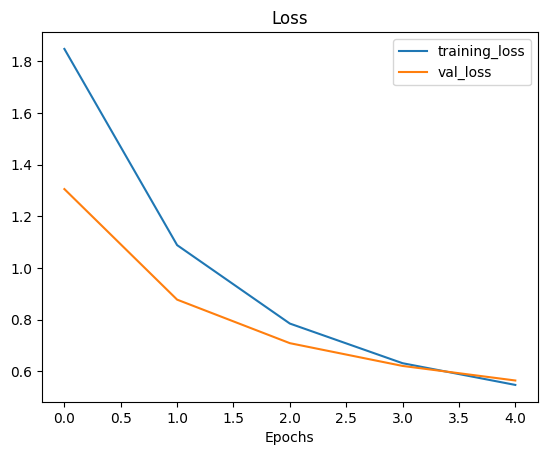

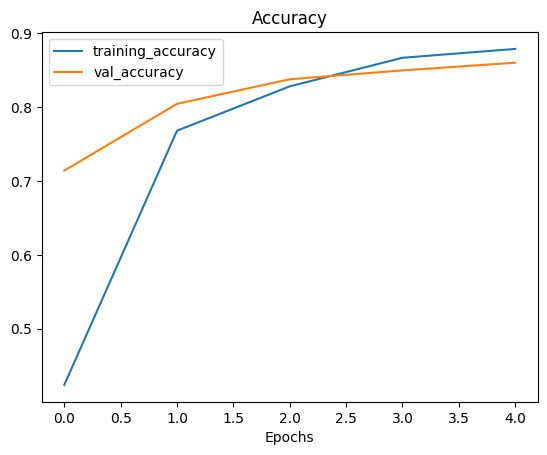

In [17]:
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

In [18]:
input_shape = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [19]:
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [20]:
input_shape = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

global_max_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f"2D global max pooled random tensor:\n {global_max_pooled_tensor}\n")

# Check the shape
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Max Pooled 2D tensor: {global_max_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global max pooled random tensor:
 [[0.9058464 1.1603122 1.6994323]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Max Pooled 2D tensor: (1, 3)


In [21]:
tf.reduce_max(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

## Running a series of transfer learning experiments

- **`model_1`** - use feature extraction transfer learning with 1% of the training data with data augmentation
* **`model_2`** - use feature extraction transfer learning with 10% of the training with data augmentaton
- **`model_3`** - use fine-tuning transfer learning on 10% of the training data with data augmentation
* **`model_4`** - use fine-tuning transfer learning on 100% of the training data with data augmentation

In [22]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-04-26 03:22:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.250.31.128, 142.251.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  46.3MB/s    in 2.7s    

2023-04-26 03:22:51 (46.3 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [23]:
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [24]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'

In [25]:
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

In [26]:
print(tf.__version__)

2.12.0


In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255)
], name="data_augmentation")

### Visualize our data augmentation layer

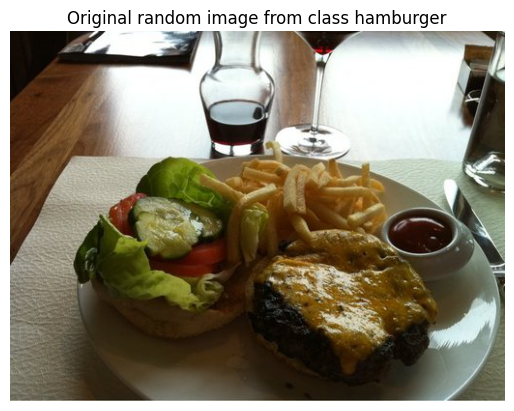

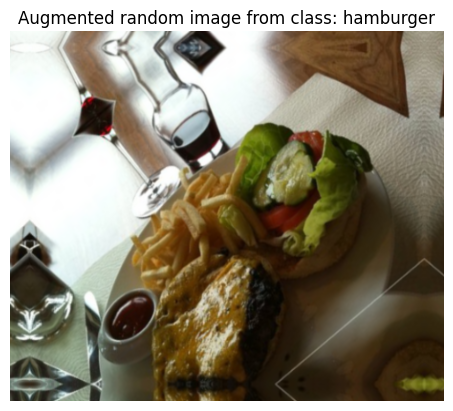

In [28]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False);

# Now, let's plot our augmented image.
augmented_img = data_augmentation(img)
plt.figure()
plt.imshow(augmented_img/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [29]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Input layer
input = layers.Input(shape=input_shape, name="input_layer")

x = data_augmentation(inputs)

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

model_1 = keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230426-032257
Epoch 1/5
3/3 [==============================] - 16s 4s/step - loss: 2.3542 - accuracy: 0.1429 - val_loss: 2.2016 - val_accuracy: 0.2188
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1031 - accuracy: 0.3571 - val_loss: 2.0506 - val_accuracy: 0.3191
Epoch 3/5
3/3 [==============================] - 4s 1s/step - loss: 1.8862 - accuracy: 0.3857 - val_loss: 1.9361 - val_accuracy: 0.3964
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.6708 - accuracy: 0.6571 - val_loss: 1.8237 - val_accuracy: 0.4836
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.5125 - accuracy: 0.6714 - val_loss: 1.7438 - val_accuracy: 0.5296


In [30]:
IMG_SIZE + (3,)

(224, 224, 3)

In [31]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [32]:
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 8s 94ms/step - loss: 1.7355 - accuracy: 0.5384


[1.7355246543884277, 0.5383999943733215]

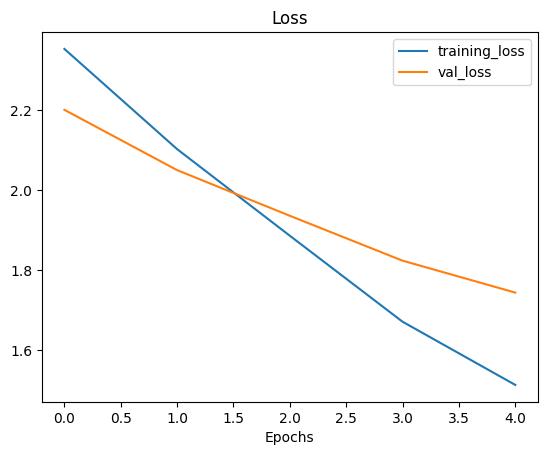

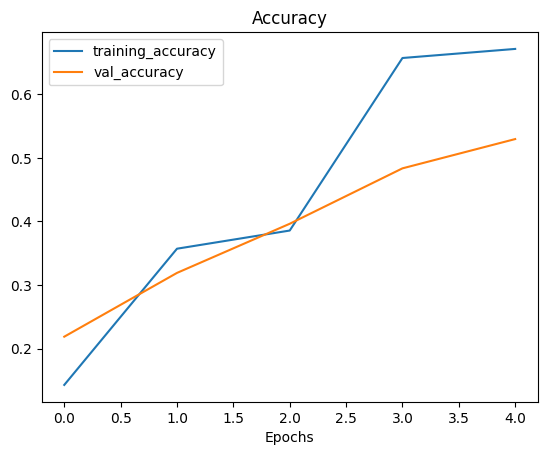

In [33]:
plot_loss_curves(history_1_percent)

## Model 2: 10% Training Data with Data Augmentation

In [34]:
tf.random.set_seed(42)

input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Input layer
input = layers.Input(shape=input_shape, name="input_layer")

x = data_augmentation(inputs)

x = base_model(x)

x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

model_2 = keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_2 = model_1.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                              experiment_name="10_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230426-032351
Epoch 1/5
24/24 [==============================] - 25s 969ms/step - loss: 1.5825 - accuracy: 0.5600 - val_loss: 1.1656 - val_accuracy: 0.7400
Epoch 2/5
24/24 [==============================] - 16s 657ms/step - loss: 1.1600 - accuracy: 0.7200 - val_loss: 0.8788 - val_accuracy: 0.8004
Epoch 3/5
24/24 [==============================] - 17s 701ms/step - loss: 0.9284 - accuracy: 0.7853 - val_loss: 0.7423 - val_accuracy: 0.8240
Epoch 4/5
24/24 [==============================] - 14s 589ms/step - loss: 0.7956 - accuracy: 0.8027 - val_loss: 0.6526 - val_accuracy: 0.8428
Epoch 5/5
24/24 [==============================] - 23s 987ms/step - loss: 0.7193 - accuracy: 0.8107 - val_loss: 0.6018 - val_accuracy: 0.8500


In [35]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Creating a ModelCheckpoint callback

In [67]:
checkpoint_path = "ten_percent_model_checkpoint_weights/checkpoint.ckpt"

# Create a ModelCheckpoing callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)

In [68]:
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          steps_per_epoch=len(train_data_10_percent),
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                            experiment_name="10_percent_data_aug"),
                                                    checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230426-033332
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.8147
Epoch 1: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 6s 239ms/step - loss: 0.6925 - accuracy: 0.8147 - val_loss: 0.5721 - val_accuracy: 0.8125
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.3567 - accuracy: 0.8880
Epoch 2: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 6s 242ms/step - loss: 0.3567 - accuracy: 0.8880 - val_loss: 0.4422 - val_accuracy: 0.8569
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.2583 - accuracy: 0.9293
Epoch 3: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 7s 248ms/step - loss: 0.2583 - accuracy: 0.9293 - val_loss: 0.4057 - val_accuracy: 0.8618
Epoch 4

In [71]:
results_10_percent_data_aug = model_2.evaluate(test_data)

79/79 [==============================] - 9s 107ms/step - loss: 0.3989 - accuracy: 0.8792


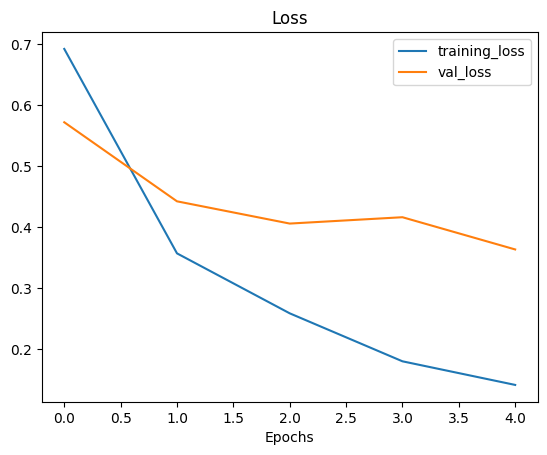

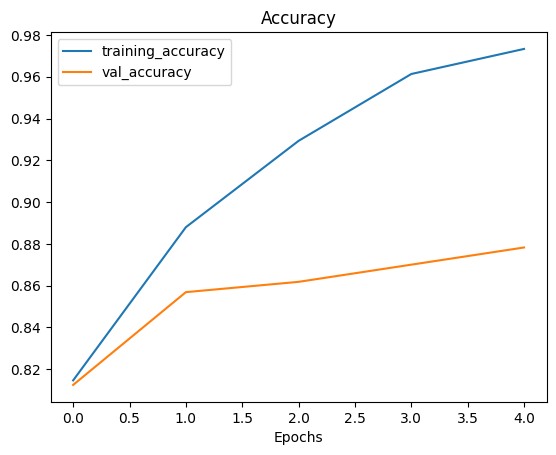

In [72]:
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

In [73]:
model_2.load_weights(checkpoint_path)

In [74]:
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 7s 81ms/step - loss: 0.3989 - accuracy: 0.8792


## Model 3: Fine-tuning an existing model on 10% of the data

In [75]:
model_2.layers

In [76]:
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f6510c63340> True
<keras.engine.sequential.Sequential object at 0x7f64f0b4e310> True
<keras.engine.functional.Functional object at 0x7f64f0267220> True
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f64eb41a3a0> True
<keras.layers.core.dense.Dense object at 0x7f64f0233cd0> True


In [77]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [78]:
print(len(model_2.layers[2].trainable_variables))

10


In [79]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

  model_2.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=["accuracy"])

In [80]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [81]:
print(len(model_2.trainable_variables))

12


In [82]:
print(len(model_2.layers[2].trainable_variables))

10


In [83]:
history_10_percent_data_aug.epoch

[0, 1, 2, 3, 4]

In [84]:
fine_tune_epochs = initial_epochs + 5

history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1],
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230426-033617
Epoch 5/10
24/24 [==============================] - 17s 301ms/step - loss: 0.1204 - accuracy: 0.9773 - val_loss: 0.3855 - val_accuracy: 0.8635
Epoch 6/10
24/24 [==============================] - 5s 181ms/step - loss: 0.0929 - accuracy: 0.9867 - val_loss: 0.3836 - val_accuracy: 0.8750
Epoch 7/10
24/24 [==============================] - 5s 210ms/step - loss: 0.0848 - accuracy: 0.9840 - val_loss: 0.3699 - val_accuracy: 0.8783
Epoch 8/10
24/24 [==============================] - 6s 218ms/step - loss: 0.0756 - accuracy: 0.9920 - val_loss: 0.3480 - val_accuracy: 0.8816
Epoch 9/10
24/24 [==============================] - 6s 219ms/step - loss: 0.0834 - accuracy: 0.9893 - val_loss: 0.3495 - val_accuracy: 0.8882
Epoch 10/10
24/24 [==============================] - 6s 216ms/step - loss: 0.0679 - accuracy: 0.9893 - val_loss: 0.3449 - val_accuracy: 0.8816


In [85]:
# Evaluate the fine-tuned model(model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 7s 85ms/step - loss: 0.3697 - accuracy: 0.8840


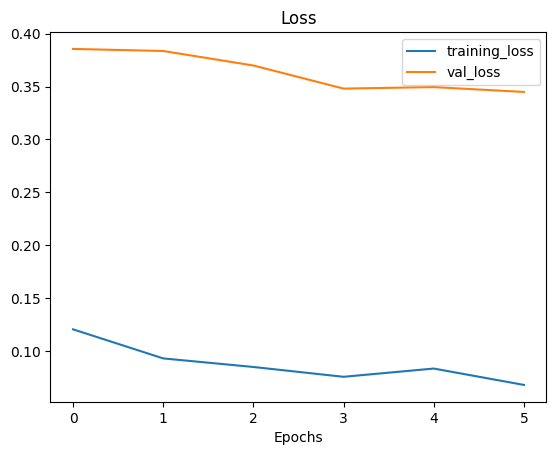

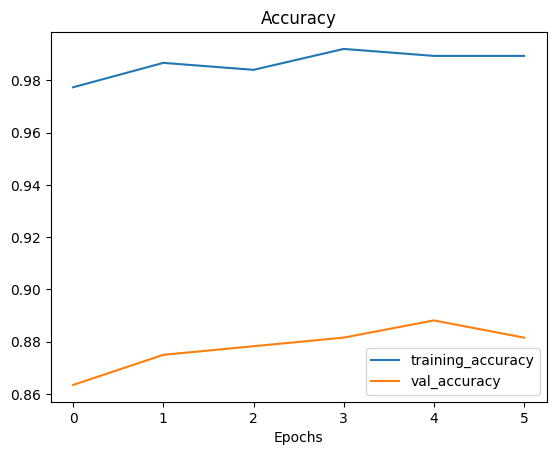

In [86]:
plot_loss_curves(history_fine_10_percent_data_aug)

In [87]:
def compare_historys(original_history, new_history, initial_epochs=5):
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Plot for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  # print(plt.ylim())
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Plot for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  # print(plt.ylim())
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Accuracy")

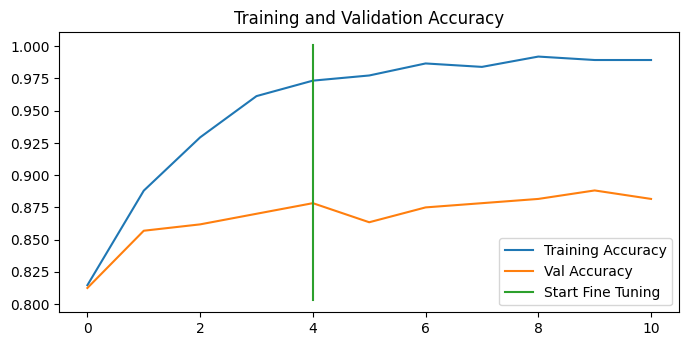

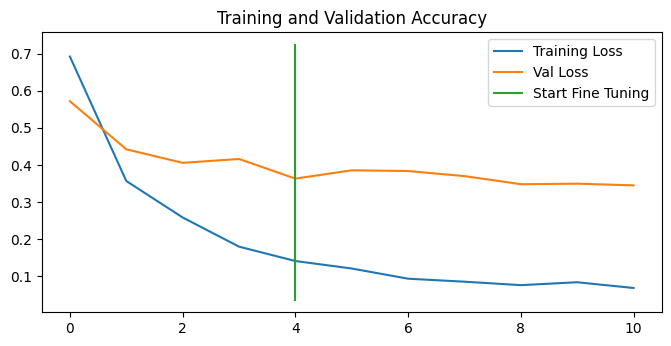

In [88]:
compare_historys(history_10_percent_data_aug,
                 history_fine_10_percent_data_aug,
                 initial_epochs=5)

## Model_4: Fine-tuning and existing model on all of the data

In [89]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2023-04-26 03:37:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 172.253.63.128, 142.251.163.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M  89.2MB/s    in 5.2s    

2023-04-26 03:37:20 (95.9 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [90]:
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [91]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 

In [92]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [93]:
model_2.evaluate(test_data)

79/79 [==============================] - 7s 83ms/step - loss: 0.3697 - accuracy: 0.8840


[0.3696787655353546, 0.8840000033378601]

In [94]:
results_fine_tune_10_percent

[0.3696787357330322, 0.8840000033378601]

To train a fine-tuning model (model_4), we need to revert model_2 back to its feature extraction weights.

In [110]:
# Load weights from checkpoint
model_2.load_weights(checkpoint_path)

In [111]:
model_2.evaluate(test_data)

79/79 [==============================] - 9s 83ms/step - loss: 0.3989 - accuracy: 0.8792


[0.3988930284976959, 0.8791999816894531]

In [112]:
results_10_percent_data_aug

[0.39889299869537354, 0.8791999816894531]

In [113]:
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [114]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7f64f0a3c220> False
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f64eb3c4430> False
2 <keras.layers.preprocessing.normalization.Normalization object at 0x7f64eb3b9040> False
3 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f64efb69a90> False
4 <keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f64eb3d7460> False
5 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f64f0a238e0> False
6 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f64f0a58880> False
7 <keras.layers.core.activation.Activation object at 0x7f64eb3e6850> False
8 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f64eb3d7fa0> False
9 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f64efb8a4f0> False
10 <keras.layers.core.activation.Activation object at 0x7f64eb3f70a0> False
11 <keras.layers.pooling.global_average_pool

In [115]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [116]:
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230426-035454


Epoch 5/10
235/235 [==============================] - 53s 181ms/step - loss: 0.5995 - accuracy: 0.8140 - val_loss: 0.2767 - val_accuracy: 0.9145
Epoch 6/10
235/235 [==============================] - 40s 166ms/step - loss: 0.5064 - accuracy: 0.8405 - val_loss: 0.2684 - val_accuracy: 0.9276
Epoch 7/10
235/235 [==============================] - 30s 128ms/step - loss: 0.4515 - accuracy: 0.8559 - val_loss: 0.2550 - val_accuracy: 0.9211
Epoch 8/10
235/235 [==============================] - 30s 127ms/step - loss: 0.4128 - accuracy: 0.8717 - val_loss: 0.2459 - val_accuracy: 0.9293
Epoch 9/10
235/235 [==============================] - 29s 122ms/step - loss: 0.3933 - accuracy: 0.8755 - val_loss: 0.2069 - val_accuracy: 0.9408
Epoch 10/10
235/235 [==============================] - 29s 123ms/step - loss: 0.3706 - accuracy: 0.8795 - val_loss: 0.2235 - val_accuracy: 0.9326


In [116]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

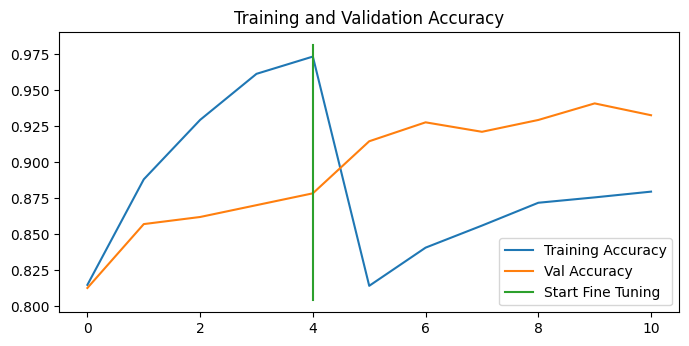

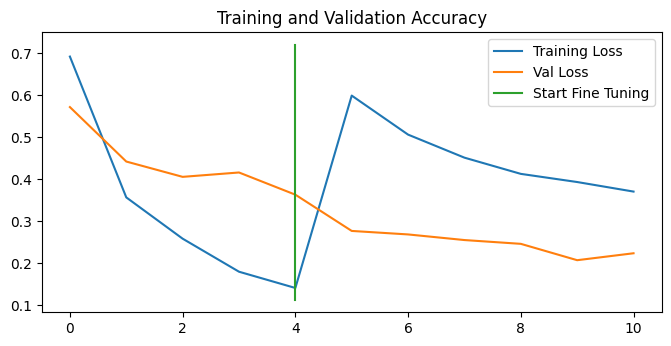

In [117]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

## Viewing our experiment data on TensorBoard

In [120]:
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 Classes" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning." \
  --one_shot

2023-04-26 04:04:06.385697: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   NKW-FHC-QNC



New experiment created. View your TensorBoard at: https://tensorboard.dev/